##Initialization

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from collections import defaultdict
import random
np.random.seed(212)

In [73]:
import requests
import zipfile
import io

# URL of the dataset.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

# Download the dataset.
response = requests.get(url)

# Unzip the downloaded content.
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()

## Data preprocessing/tokenization

In [74]:
# Number of states (ham, spam) and features.
n_states = 2

# Maximum number of words that will be defined its sown token.
n_features = 400

# Load the dataset.
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])

# Map labels ham/spam to binary values.
df['Label'] = df['Label'].map({'ham': 0, 'spam': 1})

# Train/Val/Test split: 80%/10%/10%
train_data = df.sample(n=int((df.shape[0])*0.8), random_state=10)
rem = df.drop(train_data.index)
val_data = rem.sample(n=int((rem.shape[0])*0.5), random_state=10)
test_data = rem.drop(val_data.index)

# Extract text data and labels.
train_text = train_data['Message'].tolist()
train_labels = train_data['Label'].tolist()
val_text = val_data['Message'].tolist()
val_labels = val_data['Label'].tolist()
test_text = test_data['Message'].tolist()
test_labels = test_data['Label'].tolist()

train_text = train_text[:500]
train_labels = train_labels[:500]
val_text = val_text[:100]
val_labels = val_labels[:100]
test_text = test_text[:100]
test_labels = test_labels[:100]

# Initialize a vocabulary and assign each unique word an integer ID.
word_to_id = defaultdict(lambda: len(word_to_id))

# Special tokens for padding and unknown words
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word_to_id[PAD_TOKEN] = 0
word_to_id[UNK_TOKEN] = 1

# Function to tokenize and encode each message.
def tokenize_and_encode(msgs, word_to_id):
    encoded_sequences = []
    for msg in msgs:
        tokens = msg.split()
        encoded_msg = [word_to_id[token] if token in word_to_id else word_to_id[UNK_TOKEN]
                           for token in tokens]
        encoded_sequences.append(encoded_msg)
    return encoded_sequences

In [75]:
# Assign each string in the dataset a token
text_data_shuffle = train_data['Message'].tolist()
random.shuffle(text_data_shuffle)
for message in text_data_shuffle:
  tokens = message.split() # Split the strings in each message to process every word separately.
  for token in tokens:
    if len(word_to_id) >= n_features: # Cap the dictionary length to the defined number of features to prevent overfitting.
      break
    _ = word_to_id[token] # If a word isn't already assigned a token, give it a token.
  if len(word_to_id) >= n_features:
    break

In [76]:
# Preview of the vocabulary that will be used for the emmission probabilities.
print("Vocabulary:", dict(word_to_id))

Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'Sorry,': 2, "I'll": 3, 'call': 4, 'later': 5, 'Ok': 6, 'i': 7, 'will': 8, 'tell': 9, 'her': 10, 'to': 11, 'stay': 12, 'out.': 13, 'Yeah': 14, 'its': 15, 'been': 16, 'tough': 17, 'but': 18, 'we': 19, 'are': 20, 'optimistic': 21, 'things': 22, 'improve': 23, 'this': 24, 'month.': 25, 'New': 26, 'Theory:': 27, 'Argument': 28, 'wins': 29, 'd': 30, 'SITUATION,': 31, 'loses': 32, 'the': 33, 'PERSON.': 34, 'So': 35, 'dont': 36, 'argue': 37, 'with': 38, 'ur': 39, 'friends': 40, 'just..': 41, '.': 42, 'kick': 43, 'them': 44, '&amp;': 45, 'say,': 46, "I'm": 47, 'always': 48, 'correct.!': 49, 'ok....take': 50, 'care.umma': 51, 'you': 52, 'too...': 53, 'Yes': 54, 'watching': 55, 'footie': 56, 'worried': 57, "we're": 58, 'going': 59, 'blow': 60, 'it': 61, '-': 62, 'Phil': 63, 'Neville?': 64, 'Hope': 65, 'text': 66, 'meets': 67, 'smiling.': 68, 'If': 69, 'not': 70, 'then': 71, 'let': 72, 'give': 73, 'a': 74, 'reason': 75, 'smile.': 76, 'Have': 77, 'beautiful': 7

In [77]:
# Apply tokenization and encoding to dataset.
token_text = tokenize_and_encode(train_text, word_to_id)

# Pad sequences to the same length for batch processing.
def pad_sequences(sequences, max_length, pad_value=0):
  padded_sequences = []
  for seq in sequences:
    if len(seq) < max_length:
      padded_seq = seq + [pad_value] * (max_length - len(seq))
    else:
      padded_seq = seq[:max_length]
    padded_sequences.append(padded_seq)
  return padded_sequences

# Set a maximum sequence length.
max_length = 50

#Tokenize the training, validation, and test sequences
train_sequences = pad_sequences(token_text, max_length, pad_value=word_to_id[PAD_TOKEN])
val_sequences = pad_sequences(tokenize_and_encode(val_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])
test_sequences = pad_sequences(tokenize_and_encode(test_text, word_to_id), max_length, pad_value=word_to_id[PAD_TOKEN])

# Convert sequences and labels to PyTorch tensors.
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_sequences = torch.tensor(val_sequences, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_sequences = torch.tensor(test_sequences, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

##Viterbi algorithm and training

In [85]:
# Define transitions.
A = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_states), dim=0)).float()

# Define emissions.
b = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states,n_features), dim=0)).float()

# Define initial state probabilities; state priors.
pi = nn.Parameter(nn.functional.log_softmax(torch.randn(n_states), dim=0)).float()

In [79]:
def viterbi_decoding(observed_sequences, A, b, pi):

  batch_size, seq_len = observed_sequences.shape
  n_states = A.shape[0]

  # Initialize omega and psi.
  omega = torch.zeros(batch_size, seq_len, n_states).float()
  psi = torch.zeros(batch_size, seq_len, n_states).long()

  # Enable CUDA if available.
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  observed_sequences = observed_sequences.to(device)
  A = A.to(device)
  b = b.to(device)
  pi = pi.to(device)
  omega = omega.to(device)
  psi = psi.to(device)

  # Initialize the omega value.
  omega[:, 0, :] = pi + b[:, observed_sequences[:, 0]].T

  # Recursion.
  for t in range(1, seq_len):
    omega_tminus1 = omega[:, t-1, :].unsqueeze(2)
    log_transition = omega_tminus1 + A.unsqueeze(0)

    # Get max probabilities and their indices.
    max_log_probs, psi[:, t, :] = log_transition.max(dim=1)
    omega[:, t, :] = max_log_probs + b[:, observed_sequences[:, t]].T

  # Backtrace to find the most probable states.
  best_paths = torch.zeros(batch_size, seq_len).long()
  best_paths = best_paths.to(device)
  best_paths[:, -1] = omega[:, -1, :].argmax(dim=1)

  for t in range(seq_len - 2, -1, -1):
    best_paths[:, t] = psi[torch.arange(batch_size), t + 1, best_paths[:, t + 1]]

  # The log probability of the best paths can be accessed from the omega matrix.
  log_prob = omega[torch.arange(batch_size), -1, best_paths[:, -1]]

  return best_paths, log_prob

In [84]:
epochs = 100
batch_size = 32
lr = 0.0001

def train_hmm(observed_sequences, A, b, pi, n_epochs, lr, batch_size):
  # Initialize Adam optimizer and gradient clip in case the gradient becomes too large.
  optimizer = optim.Adam([A, b, pi], lr=lr)

  # Calculate number of batches.
  batches = (len(observed_sequences) + batch_size - 1) // b

  # Initialize total loss function and enable gradient calculations.
  for epoch in range(n_epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i in range(0, len(observed_sequences), batch_size):
      batch = observed_sequences[i:i + batch_size]

      # Perform Viterbi decoding and compute negative log-likelihood loss.
      # We only need the log probability for the purposes of training.
      _, log_probs = viterbi_decoding(batch, A, b, pi)
      loss = -log_probs.sum()

      # Backpropagation.
      loss.backward()
      # Add gradient clipping in the case the gradient becomes too large.
      nn.utils.clip_grad_norm_([A, b, pi], max_norm=1.0)
      optimizer.step()

      # Add the calculated loss to the total loss.
      total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss:.4f}")

In [86]:
train_hmm(train_sequences, A, b, pi, epochs, lr, batch_size)

Epoch 1/100, Loss: 31567.7946
Epoch 2/100, Loss: 31489.3800
Epoch 3/100, Loss: 31411.0052
Epoch 4/100, Loss: 31332.6123
Epoch 5/100, Loss: 31254.2271
Epoch 6/100, Loss: 31175.8367
Epoch 7/100, Loss: 31097.4518
Epoch 8/100, Loss: 31019.0543
Epoch 9/100, Loss: 30940.6658
Epoch 10/100, Loss: 30862.2716
Epoch 11/100, Loss: 30783.8760
Epoch 12/100, Loss: 30705.4819
Epoch 13/100, Loss: 30627.0874
Epoch 14/100, Loss: 30548.6937
Epoch 15/100, Loss: 30470.2986
Epoch 16/100, Loss: 30391.9053
Epoch 17/100, Loss: 30313.5122
Epoch 18/100, Loss: 30235.1141
Epoch 19/100, Loss: 30156.7128
Epoch 20/100, Loss: 30078.3176
Epoch 21/100, Loss: 29999.9156
Epoch 22/100, Loss: 29921.5171
Epoch 23/100, Loss: 29843.1144
Epoch 24/100, Loss: 29764.7141
Epoch 25/100, Loss: 29686.3195
Epoch 26/100, Loss: 29607.9227
Epoch 27/100, Loss: 29529.5269
Epoch 28/100, Loss: 29451.1318
Epoch 29/100, Loss: 29372.7368
Epoch 30/100, Loss: 29294.3353
Epoch 31/100, Loss: 29215.9396
Epoch 32/100, Loss: 29137.5383
Epoch 33/100, Los

## Evaluating the data with inference, ROC curve, and confusion matrix

In [94]:
def predict_labels(observed_sequences, labels, A, b, pi):
#For inference purposes, we only need the best paths from our Viterbi decoding function.
  pred, _ = viterbi_decoding(observed_sequences, A, b, pi)
  states = pred[:,-1]
  print(states)
  correct = (states == labels).sum().item()
  total = labels.numel()
  accuracy = correct / total
  return accuracy, states

In [95]:
val_results, _ = predict_labels(val_sequences, val_labels, A, b, pi)
print(val_labels)
print(val_results)

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
0.14


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
0.0


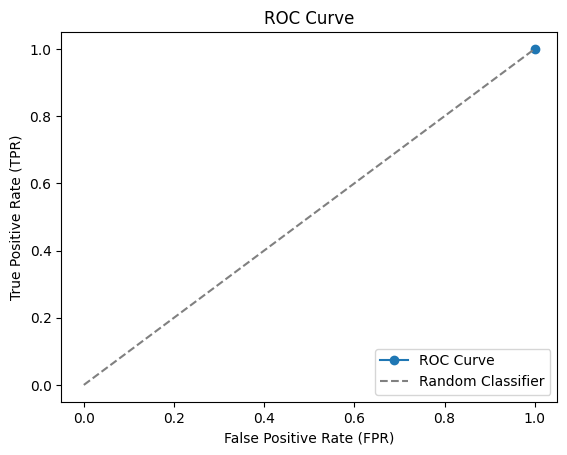

In [96]:
import matplotlib.pyplot as plt

true = test_labels.numpy()
_, pred = predict_labels(test_sequences, test_labels, A, b, pi)
pred = pred.numpy()

# Sort by predicted scores in descending order.
sorted_indices = np.argsort(-pred)
true = true[sorted_indices]
pred = pred[sorted_indices]

thresh = np.unique(pred)
tpr = []  # True positive rate.
fpr = []  # False positive rate.

# Total positives and negatives.
P = sum(true)
N = len(true) - P

# Iterate through thresholds.
for t in thresh:
  # Classify predictions as positive or negative.
  lab = (pred >= t)

  TP = np.sum((lab == 1) & (true == 1))
  FP = np.sum((lab == 1) & (true == 0))
  FN = np.sum((lab == 0) & (true == 1))
  TN = np.sum((lab == 0) & (true == 0))

  # Calculate TPR and FPR.
  tpr.append(TP/P)
  fpr.append(FP/N)

auc = np.trapz(tpr, fpr)
print(auc)

plt.figure()
plt.plot(fpr, tpr, marker='o', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()